In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime

In [2]:
import tools

In [3]:
data = pd.read_json('data/flink/pr-flat_20220602-13h35m41s_apache_flink_master_prs-brief.txt', lines=True)

In [4]:
data = tools.create_label_dataset(data)
tools.initialize_datetime(data)
data['lifetime'] = tools.add_lifetime_column(data)
data = data.set_index('createdAt')

In [5]:
data['_count'] = 1
data = data[['name', 'number', 'lifetime', '_count']]
data

,name,number,lifetime,_count
createdAt,,,,
2014-06-10 16:51:08+00:00,component=Deployment/YARN,1,0 days 02:51:06,1
2014-06-10 22:31:31+00:00,component=Runtime/Network,5,6 days 23:47:47,1
2014-06-11 10:16:58+00:00,component=<none>,6,6 days 12:02:20,1
2014-06-12 09:00:26+00:00,component=<none>,8,1 days 06:37:45,1
2014-06-12 14:23:29+00:00,component=<none>,11,0 days 07:03:46,1
...,...,...,...,...
2022-06-01 08:12:33+00:00,component=TableSQL/Planner,19860,NaT,1
2022-06-01 10:34:44+00:00,component=Deployment/YARN,19863,NaT,1
2022-06-01 12:47:53+00:00,component=Runtime/Checkpointing,19864,NaT,1


In [6]:
for el in data['name'].unique():
    if not el.startswith('component='):
        print(el)

post-ui-rework
review=description?
review=consensus?
review=approved ✅
review=architecture?
review=quality?
dependencies
ruby
java
post-1.10-scheduler-feedback
javascript


In [7]:
key_none = '<none>'  # A component name used by the api
key_undefined = '<undefined>'  # introduced by us
data['component'] = key_undefined
data['other'] = key_undefined
data.loc[~data['name'].str.startswith('component='), 'other'] = data.loc[~data['name'].str.startswith('component='), 'name'] 
data.loc[data['name'].str.startswith('component='), 'component'] = data.loc[data['name'].str.startswith('component='), 'name'].str.replace('component=', '') 

In [8]:
data['componentPrefix'] = key_undefined
data['componentSuffix'] = key_undefined
condition = ~data['component'].isna() & data['component'].str.contains('/')
#other = ~data['component'].isna() & ~data['component'].str.contains('/')

data[['componentPrefix', 'componentSuffix']] = data['component'].str.split('/', expand=True, n=1) 
#data.loc[other, 'componentPrefix'] = data.loc[other, 'component']

In [9]:
data.loc[condition, 'component'].str.split('/', expand=True, n=1)

,0,1
createdAt,,
2014-06-10 16:51:08+00:00,Deployment,YARN
2014-06-10 22:31:31+00:00,Runtime,Network
2014-06-15 18:45:37+00:00,API,Scala
2014-06-24 13:09:41+00:00,Runtime,Coordination
2014-06-24 21:30:16+00:00,Runtime,Task
...,...,...
2022-06-01 08:12:33+00:00,TableSQL,Planner
2022-06-01 10:34:44+00:00,Deployment,YARN
2022-06-01 12:47:53+00:00,Runtime,Checkpointing


In [10]:
data.query('componentPrefix != ""')[['component', 'componentPrefix']].drop_duplicates()['componentPrefix'].value_counts()

Connectors             15
Runtime                10
API                     7
TableSQL                6
Deployment              4
BuildSystem             4
Library                 3
Documentation           3
Benchmarks              1
Client                  1
Formats                 1
chinese-translation     1
fs                      1
TestInfrastructure      1
<undefined>             1
TableStore              1
ReleaseSystem           1
FileSystems             1
Quickstarts             1
Travis                  1
flink-docker            1
CommandLineClient       1
LegacyComponents        1
ScalaShell              1
Tests                   1
flink-contrib           1
ProjectWebsite          1
Examples                1
<none>                  1
kafka                   1
Name: componentPrefix, dtype: int64

In [11]:
top_components = data['component'].dropna().value_counts()

In [12]:
(top_components / top_components.sum()).head(10)

<undefined>              0.309712
Runtime/Coordination     0.066277
TableSQL/API             0.056784
Documentation            0.052807
Tests                    0.042704
<none>                   0.040984
TableSQL/Planner         0.030917
API/Python               0.025759
Runtime/StateBackends    0.023251
API/DataStream           0.022606
Name: component, dtype: float64

In [13]:
with pd.option_context("display.max_rows", top_components.shape[0]):
    print(top_components)

<undefined>                            8645
Runtime/Coordination                   1850
TableSQL/API                           1585
Documentation                          1474
Tests                                  1192
<none>                                 1144
TableSQL/Planner                        863
API/Python                              719
Runtime/StateBackends                   649
API/DataStream                          631
BuildSystem                             549
Runtime/Task                            458
Connectors/Kafka                        447
Runtime/Network                         445
Runtime/Checkpointing                   413
Runtime/Metrics                         396
Connectors/Hive                         394
Deployment/YARN                         376
Runtime/WebFrontend                     366
Runtime/REST                            284
chinese-translation                     263
TableSQL/Runtime                        251
Connectors/Common               

[Text(0.5, 0, 'created time'), Text(0, 0.5, 'count')]

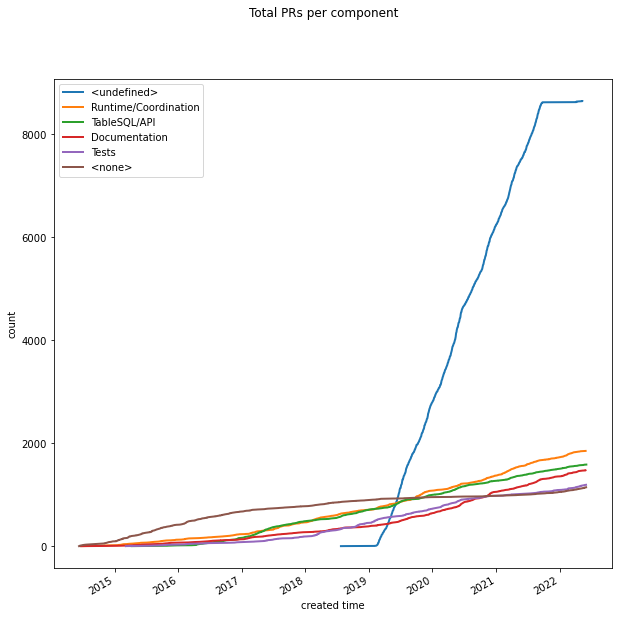

In [14]:
f, ax = plt.subplots(figsize=(10, 10))
for component in top_components.head(6).index:
    data.loc[data['component'] == component, '_count'].cumsum().plot(ax=ax, label=component, lw=2)
ax.legend()
f.suptitle('Total PRs per component')
ax.set(xlabel='created time', ylabel='count')